**Autor:** Dávid Dráb  <br> *[Prírodovedecká fakulta](https://www.upjs.sk/en/faculty-of-science/?prefferedLang=EN), Univerzita Pavla Jozefa Šafárika, Košice 2023* <br> email: [david.drab163@gmail.com](mailto:david.drab163@gmail.com).
***
**<font size=6.5 color=darkblue> Zobrazenie funkcionálnych dát </font>**  

--- 
<a id=obsah></a>

**<font size=5.5 color=darkblue> Obsah </font>** <br> 

1. [Úvod](#uvod)  


2. [Vyhladenie a zarovnanie kriviek](#vyhladenie_zarovnanie)  


3. [Optimálny počet funkcií v báze](#optimalna_baza) 


4. [Zdroje](#zdroje)

--- 

<a id=uvod></a>
**<font size=5 color=darkblue> 1. Úvod </font>** <br>

Funkcionálnym prístupom je možné modelovať dáta z rôznych oblastí. Napr. vývoj výšky ľudí, hustota reakčného času detí s ADHD, vývoj teploty alebo množstvo zrážok a pod. Dá sa povedať, že využitie tohto spôsobu je nielen v medicíne, meteorológií, ale aj v kriminalistike, matematike ako takej, či v ekonómií.  

Základnou myšlienkou funkcionálnej analýzy dát je to, že skúmanými objektami sú tzv. **hladké krivky** 

$$ x_n(t):  t \in [T_1,T_2],  n=1,2,..,N,$$

pre ktoré hodnoty $x_n(t)$ existujú v ľubovoľnom bode $t$, ale pozorujú sa iba vo vybraných bodoch $t_{j,n}$. Napr. pri medikamentóznej liečbe sa môžeme zaujímať o koncentráciu $x_n(t)$ určitej látky v krvi pacienta $n$ v čase $t$. Číslo $x_n(t)$ existuje v ľubovoľnom čase $t$, ale jeho hodnota sa meria len v nami vybranom čase, napr. pri odbere krvi raz mesačne. (Kokoszka, Reimherr 2017)

Za predpokladu, že hodnoty pozorovanej $i$-tej krivky sú súborom diskrétnych hodnôt $y_{i1},...,y_{in}$, prvou úlohou je previesť tieto hodnoty na funkciu $x_i$ s hodnotami $x_i(t)$ vypočítateľnými pre akúkoľvek hodnotu $t$. (Ramsay, Silverman 2005)

In [39]:
# instalacia a inicializacia potrebnych balikov a kniznic
options(warnings=-1)
suppressMessages(library("fda", quietly = TRUE, verbose = FALSE))
suppressMessages(library("refund", quietly = TRUE, verbose = FALSE))
data(CanadianWeather)
attach(CanadianWeather)

The following objects are masked from CanadianWeather (pos = 5):

    coordinates, dailyAv, geogindex, monthlyPrecip, monthlyTemp, place,
    province, region




V nasledujúcej ukážke môžeme vidieť príklad využitia funkcionálneho prístupu v matematike a to náhodné prechádzky konvertované do fukncionálnych objektov.

[1] "done"

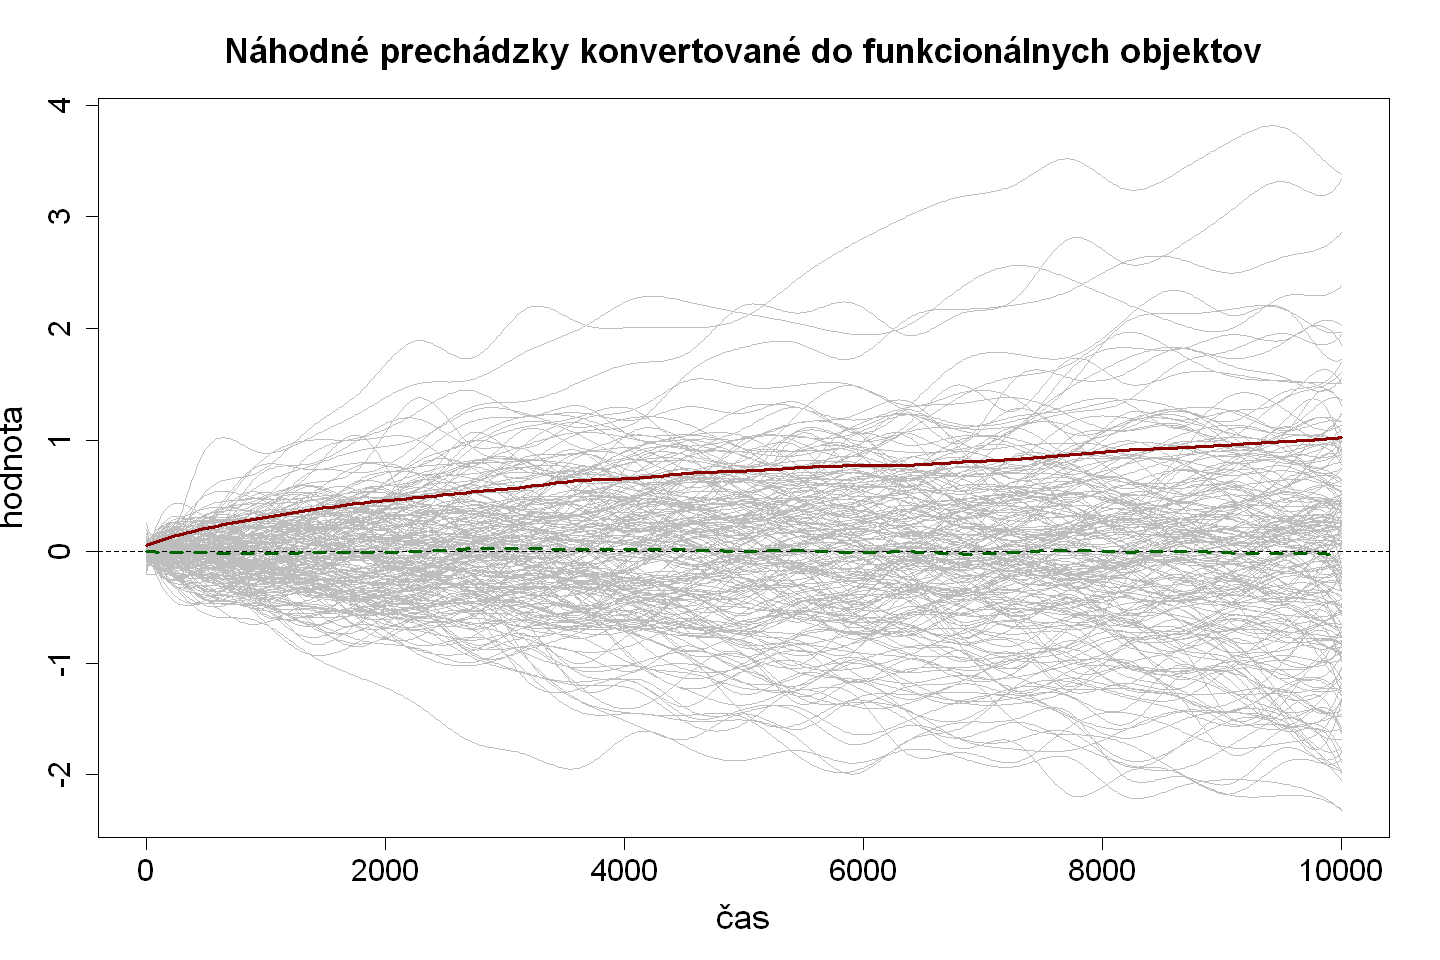

In [40]:
W.mat=matrix(0, ncol=200, nrow=10000)

for(n in 1:200){
  W.mat[, n]=cumsum(rnorm(10000))/100}

# vytvorime si bazu s poctom baz (nbasis=) 25 a na intervale 0 az 10000 - parameter rangeval=c(0,10000)
B25.basis=create.bspline.basis(rangeval=c(0,10000), nbasis=25)

# vyhladime data, kde vstupom je matica dat a vytvorena baza - mnozina bazickych funkcii
W.fd=smooth.basis(y=W.mat, fdParobj=B25.basis)

# vykreslime si vyhladene data
options(repr.plot.width=12, repr.plot.height=8)
plot(W.fd,col="grey",lty=1,main="Náhodné prechádzky konvertované do funkcionálnych objektov", xlab="čas", ylab="hodnota",
     cex.main=1.75,cex.lab=1.75, cex.axis=1.5)

# vyratame a zobrazime do grafu aj priemer a odchylku
W.mean=mean.fd(W.fd$fd)
W.sd=std.fd(W.fd$fd)
lines(W.sd, lwd=3, col="darkred") 
lines(W.mean, lty=2,lwd=3, col="darkgreen")

Otázkou je, akým spôsobom vieme tento prístup matematicky exaktne popísať? Odpoveď nám ponúka myšlienka Fourierovho rozvoja funkcie. Teda vieme písať
$$ x_{n}(t) \approx \sum^{M}_{m=1}c_{nm}B_{m}(t),
1\leq n\leq N,$$
kde $B_m(t)$ je nejaká bázická funkcia z množiny nami určených bázických funkcií a $c_{mn}$ je vektor skalárov (dimenzie $M$) pre každé $n$.   

Bázy môžu byť:
* Fourierova, B-spline, monomická, exponenciálna, vlnková, konštantná a iné.

Báza je špecifikovaná:
* svojim typom,
* rozsahom hodnôt argumentov $[T_1,T_2]$,
* počtom bázických funkcií,
* parametrom bázy.


Perspektívny 3D graf predstavuje schematické znázornenie vzťahu medzi troma premennými, z ktorých jedna je na horizontálnej a vertikálnej osi a tretia je reprezentovaná sériou čiar nakreslených tak, aby vyvolali ilúziu troch rozmerov.

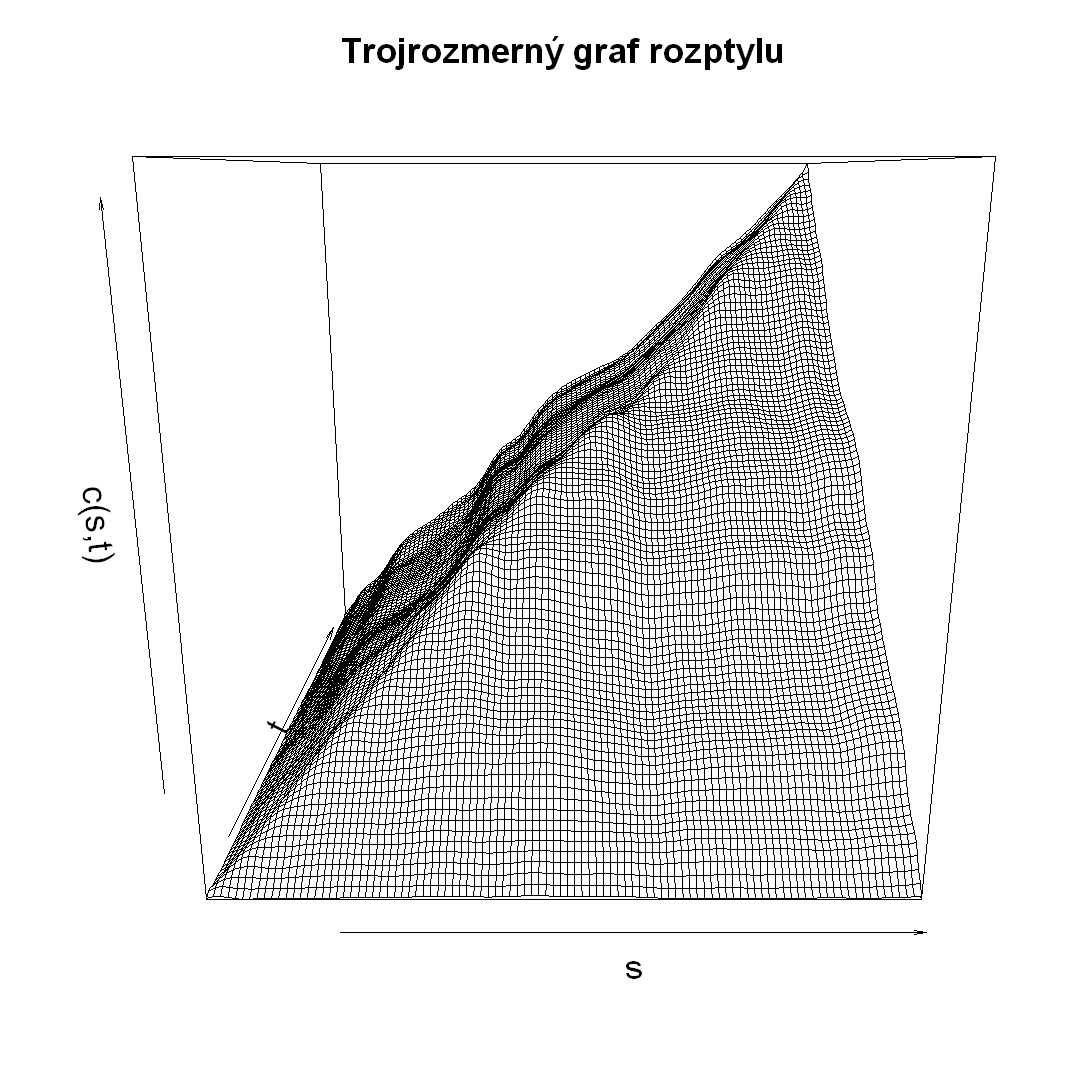

In [41]:
# vyratame si kovarianciu vyhladenych dat
W.cov=var.fd(W.fd$fd) 
grid=(1:100)*100
# vytvorime si vektor argumentov z dvojargumentoveho funkcionalneho objektu - aby sme mohli vytvorit 3D graf
W.cov.mat=eval.bifd(grid, grid, W.cov)
options(repr.plot.width=9, repr.plot.height=9)
persp(grid, grid, W.cov.mat, xlab="s",ylab="t", zlab="c(s,t)", main="Trojrozmerný graf rozptylu",cex.main=1.75,cex.lab=1.75)

---

<a id=vyhladenie_zarovnanie></a>
**<font size=5 color=darkblue> 2. Vyhladenie a zarovnanie kriviek </font>** <br>


**<font size=4 color=darkblue> 2.1 Vyhladenie kriviek </font>** <br>

Ak sa predpokladá, že dáta sú namerané s nulovou chybou, potom proces nazývame interpolácia, ale ak majú nejakú chybu merania, ktorú je potrebné odstrániť, potom prevedenie diskrétnych dát na funkciu môže obsahovať aj nejaké **vyhladenie**. (Ramsay, Silverman 2005)

Toto vyhladenie dosiahneme práve pomocou vyššie spomenutého vyjadrenia 

$$ x_{n}(t) \approx \sum^{M}_{m=1}c_{nm}B_{m}(t), 1\leq n\leq N,$$

s vhodným typom bázy a ďalších parametrov.

Najčastejšími typmi báz sú Fourierová a B-spline báza. Fourierova báza sa využíva pri krivkách, ktoré majú rovnakú počiatočnú aj koncovú hodnotu.

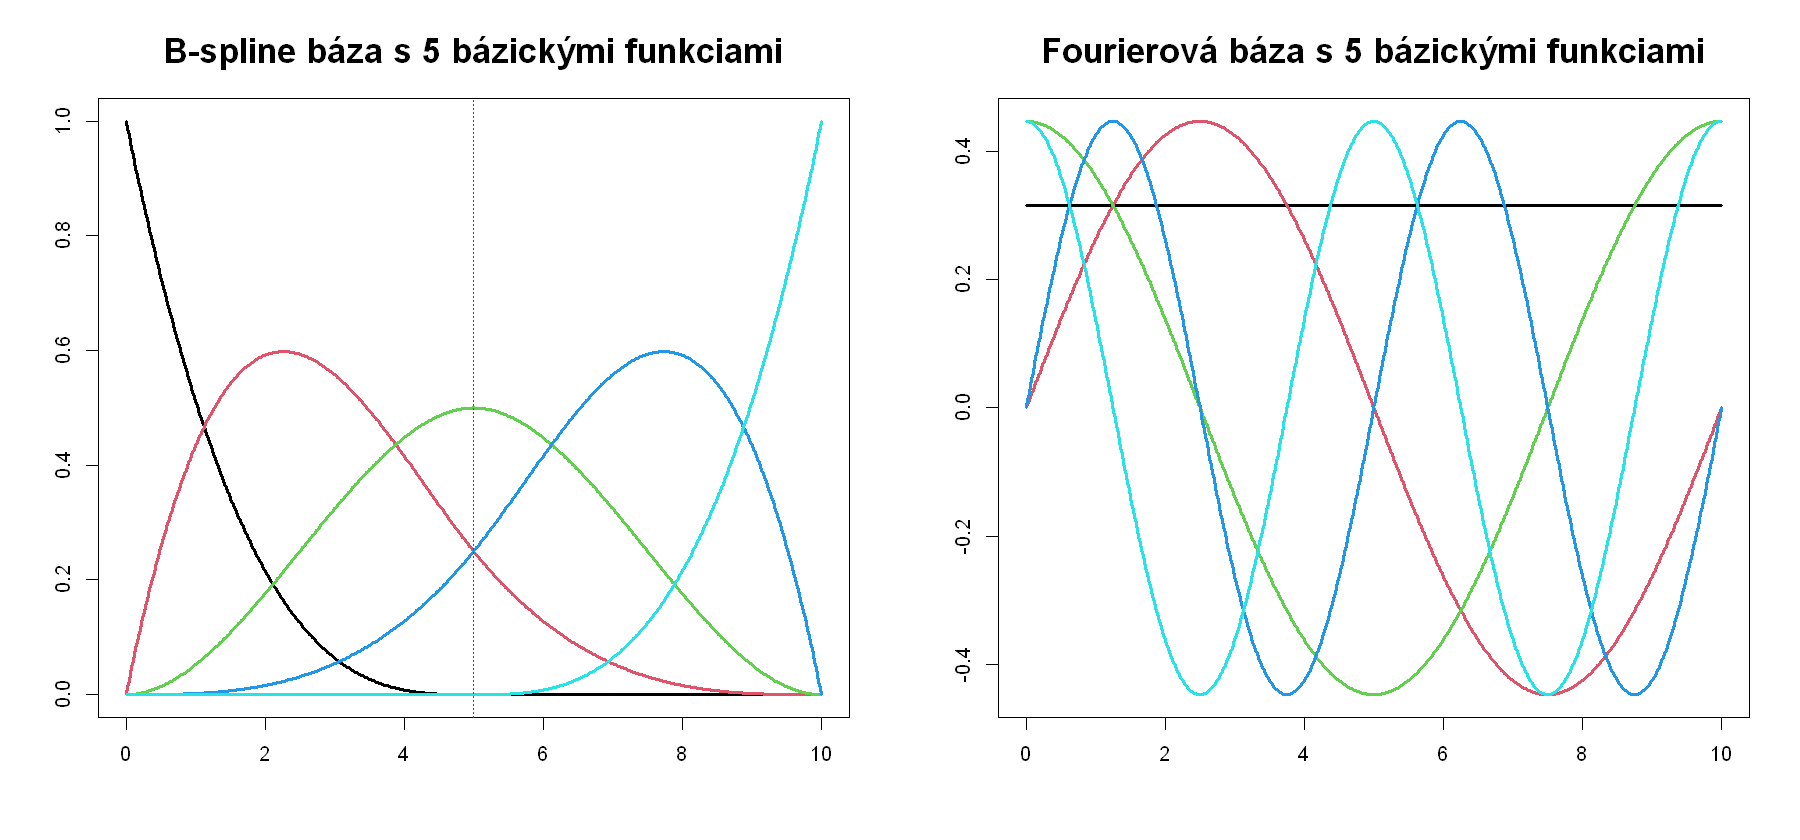

In [42]:
# vytvorime si dva typy baz a nasledne si ich vykreslime - na intervale 0 az 10 s 5 bazickymi funkciami
options(repr.plot.width=15, repr.plot.height=7)
par(mfrow=c(1,2))
spline.basis<-create.bspline.basis(rangeval=c(0,10), nbasis=5)
plot(spline.basis, lty=1, lwd=3, main="B-spline báza s 5 bázickými funkciami", cex.main=1.75, cex.lab=1.75)

fourier.basis<-create.fourier.basis(rangeval=c(0,10), nbasis=5)
plot(fourier.basis, lty=1, lwd=3, main="Fourierová báza s 5 bázickými funkciami", cex.main=1.75, cex.lab=1.75)

V prípade nie veľmi vyhladenej krivky, ako napríklad krivka náhodnej prechádzky, vieme pomocou funkcionálneho prístupu vyhladiť túto krivku rôznou mierou v závislosti od počtu funkcií v báze. Platí, že čím vyšší počet funkcií v báze, tak tým je vyhladená krivka podobnejšia pôvodnej krivke. Samotný počet funkcií v báze je limitovaný počtom pozorovaní. Vyhladenie kriviek je jednou z mnohých výhod funkcionálneho prístupu.

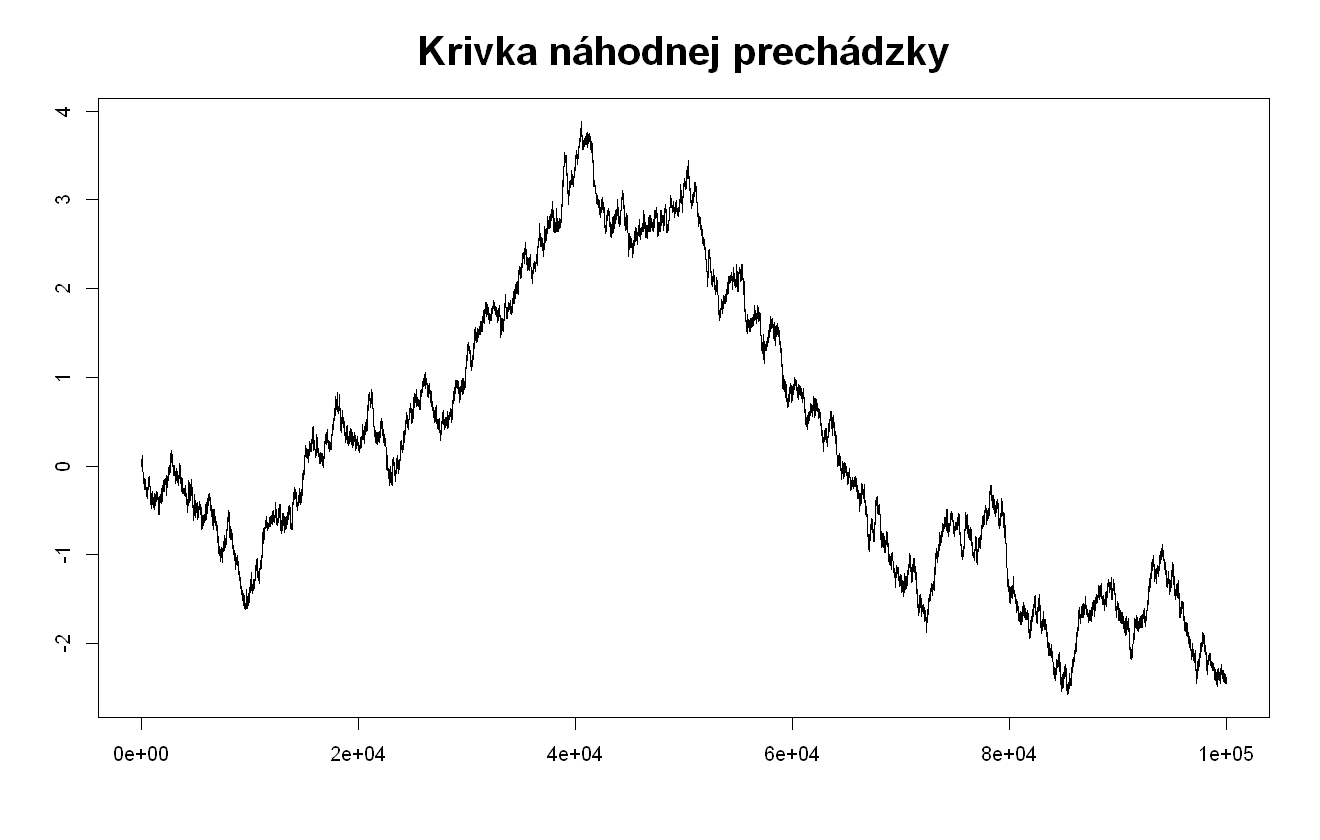

In [43]:
# vytvorime si vektor, ktory bude reprezentovat krivku nahodnej prechadzky a nasledne si krivku vykreslime 
Wiener=cumsum(rnorm(100000))/100
options(repr.plot.width=11, repr.plot.height=7)
plot.ts(Wiener, xlab="", ylab="", main="Krivka náhodnej prechádzky", cex.main=2) 

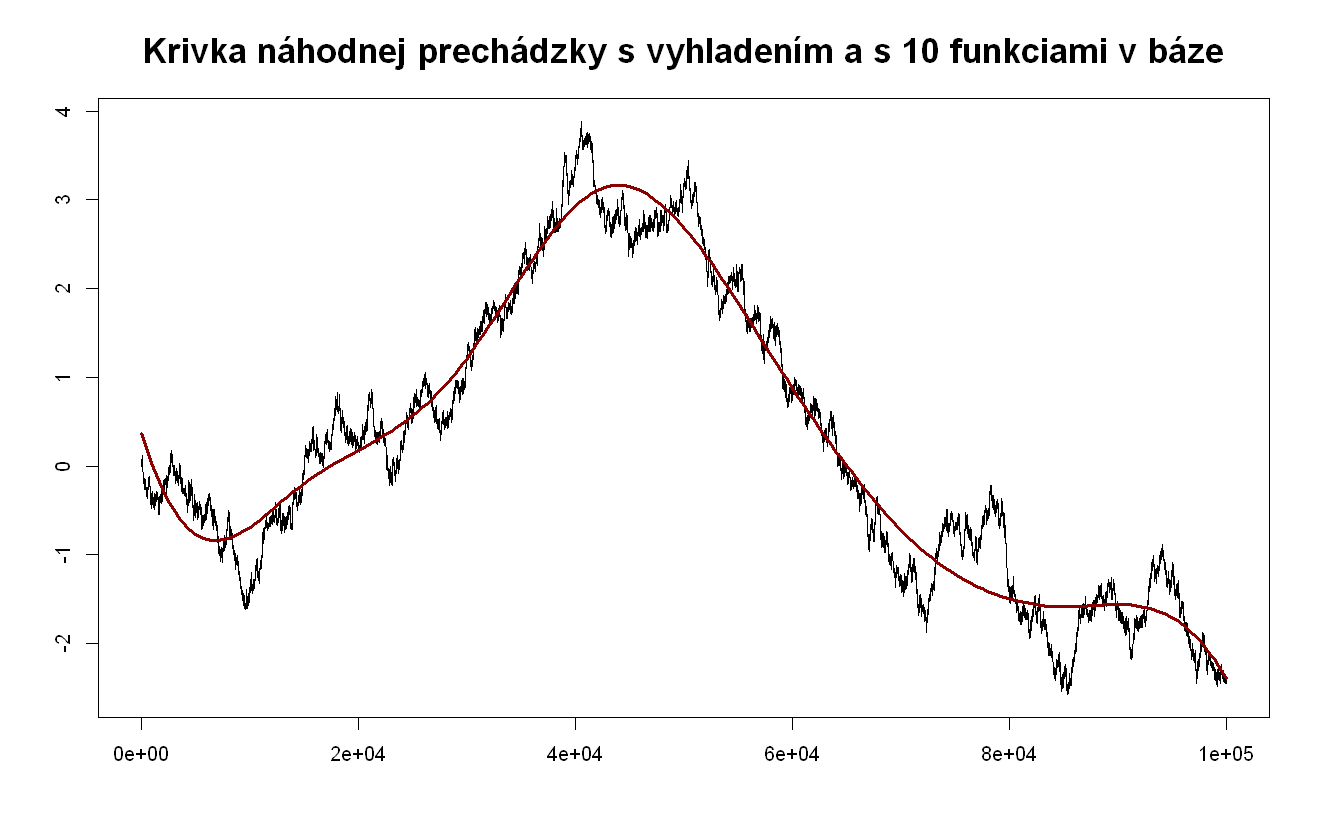

In [44]:
# vytvorime si bazu s danymi parametrami, vyhladime data a nakoniec si vsetko vykreslime
B10.basis=create.bspline.basis(rangeval=c(0,100000), nbasis=10)
Wiener.fd=smooth.basis(y=Wiener,fdParobj=B10.basis)
plot.ts(Wiener, xlab="", ylab="", main="Krivka náhodnej prechádzky s vyhladením a s 10 funkciami v báze", cex.main=1.75)
lines(Wiener.fd, lwd=3, col="darkred")

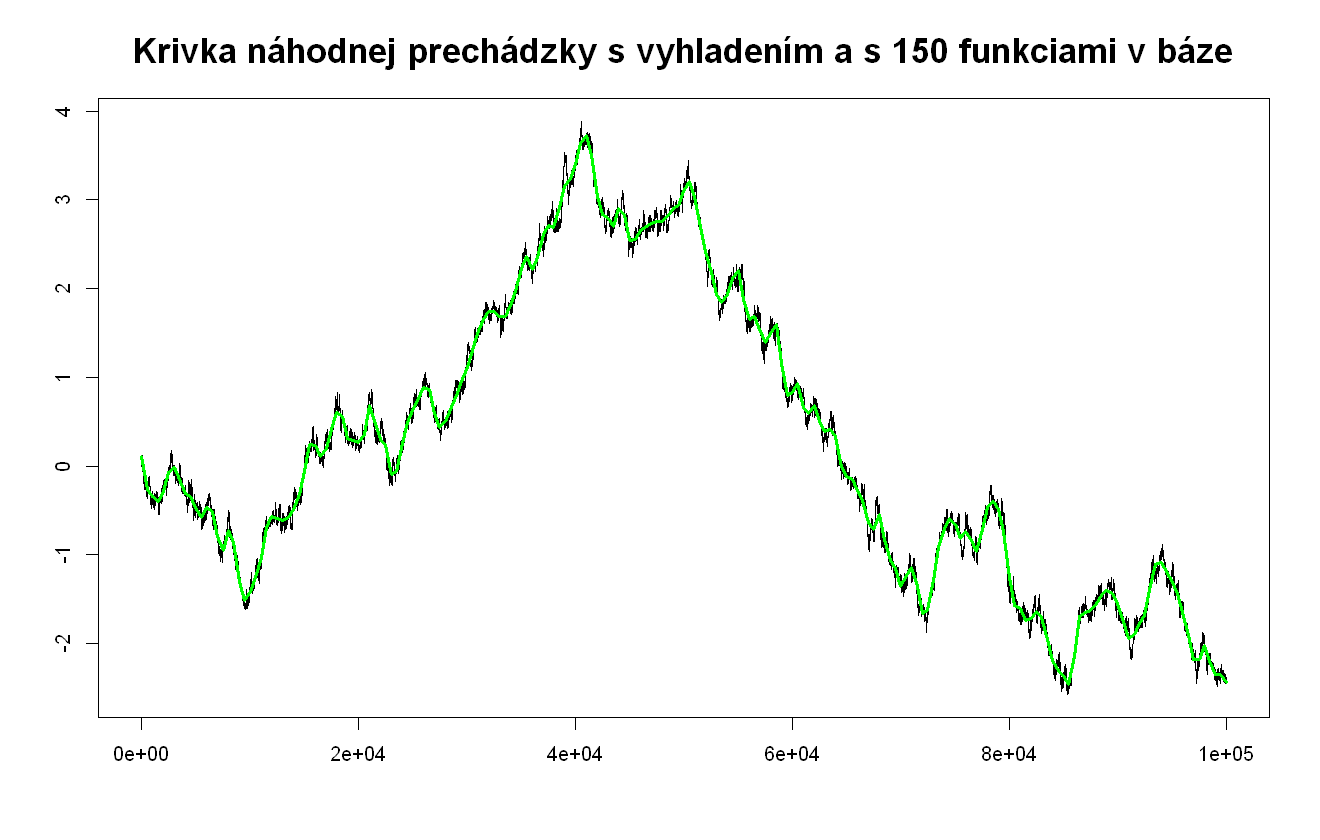

In [45]:
B150.basis=create.bspline.basis(rangeval=c(0,100000), nbasis=150)
Wiener.fd=smooth.basis(y=Wiener,fdParobj=B150.basis)
plot.ts(Wiener, xlab="", ylab="", main="Krivka náhodnej prechádzky s vyhladením a s 150 funkciami v báze", cex.main=1.75)
lines(Wiener.fd, lwd=3, col="green")

Čo v prípade, že krivka nie je dostatočne hladká a máme už dimenziu $M$ rovnú počtu funkcií v báze?

V prípade nedostatočnej hladkosti krivky nám pomôže penalizované vyhladzovanie krivky s parametrom $\lambda$. 

Zadefinujme si $L(x)(t)= \alpha_{0}(t)x(t)+\alpha_{1}(t)x^{1}(t)+...+\alpha_{m}(t)x^{m}(t)$, čo nazývame lineárny diferenciálny operátor. Potom $$PSS_{\alpha}(c_{1}, c_{2},...,c_{K}) = \displaystyle\sum\limits_{j}(y_{j}-x_{K}(t_{j}))^{2} + \lambda\int_{T_{1}}^{T_{2}}\lbrack L(x_{K})(t)\rbrack^{2} dt$$ budeme nazývať penalizovaný súčet štvorcov s parametrom vyhladenia $\lambda$. Budeme teda hľadať také $\lambda$, aby $PSS_λ$ bolo minimálne, pomocou krížovej validácie (CV - ang. _cross validation_), resp. všeobecnej krížovej validácie (GCV - ang. _general cross validation_), kde GCV skóre je definované, ako $\dfrac{N^{-1}\displaystyle\sum\limits_{n=1}^{N}(Y_{n}-\hat{Y}_{n})^{2}}{(1-N^{-1}\mathrm{tr}(H_{\lambda}))^{2}}$, kde $\mathrm{tr}(H_{\lambda})$ je stopa matice (ang. _trace_) $H_{\lambda}$. To znamená, že hľadáme také $λ$, aby GCV skóre bolo minimálne. 

V nasledujúcom kóde si ukážeme penalizované vyhladenie krivky. Kvôli prehľadnosti si vykreslíme len jednotlivé body merania zrážok v logaritmickej škále v jednom kadanskom meste. Potom aj vyhladenú krivku s maximálnym počtom funkcií v báze. Uvidíme, že krivka nebude dostatočne vyhladená. Preto využitím GCV skóre nájdeme vhodnú $λ$ a následne si vyhladenú krivku dokreslíme do pôvodného grafu. Dostaneme tak graf s meraniami a s vyhladenými krivkami na porovnanie. Môžeme potom skonštatovať, že penalizované vyhladenie je v tomto prípade prínosnejšie. 

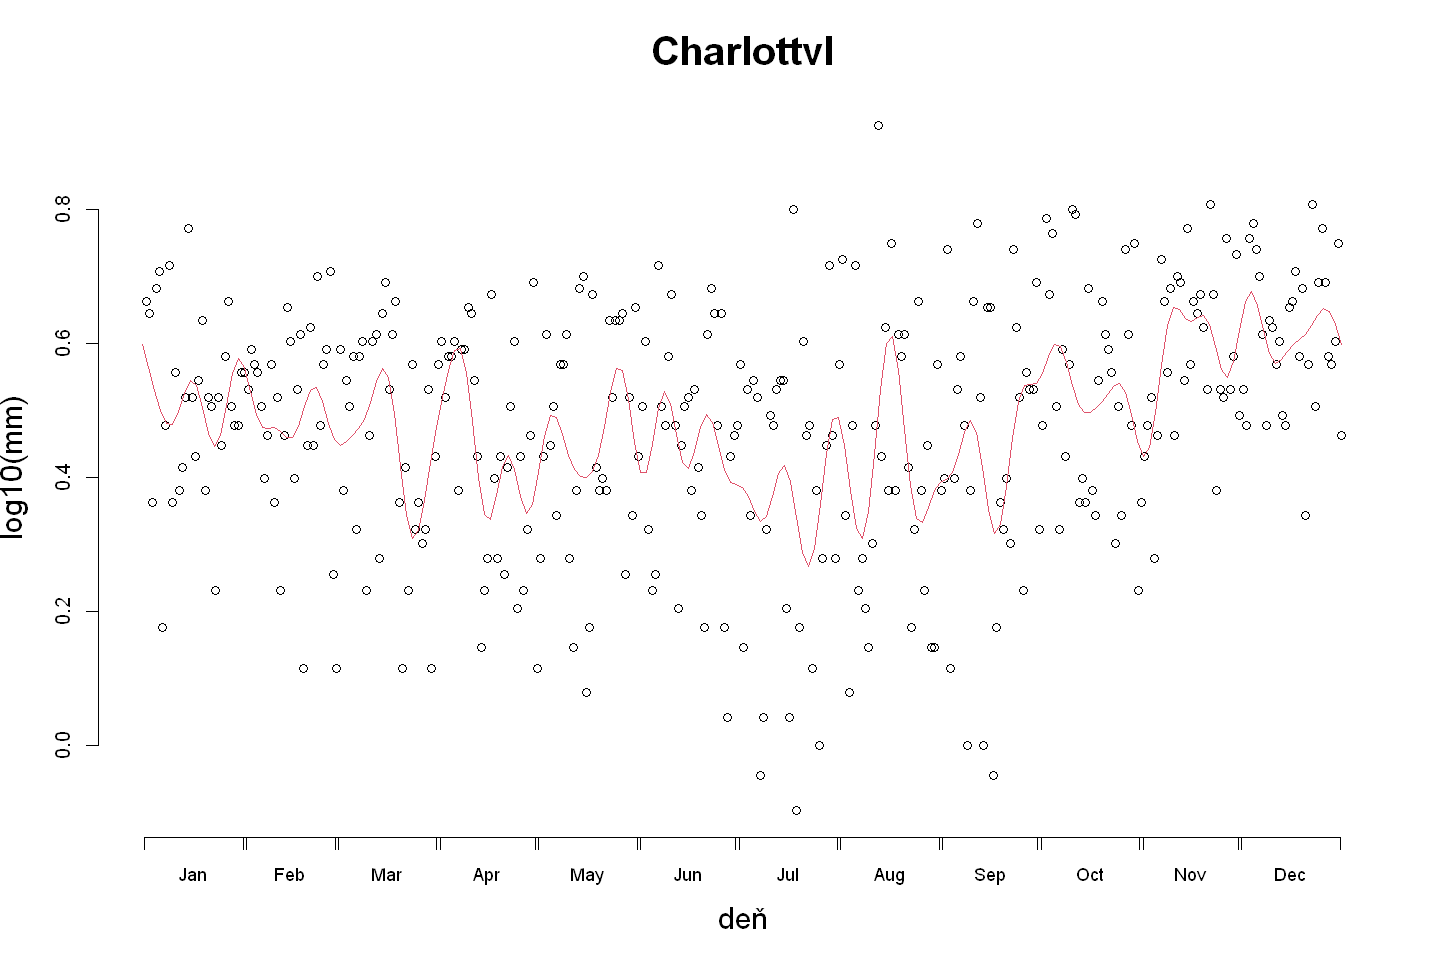

In [46]:
nbasis = 65
yearRng = c(0,365)
# vytvorime si bazu
daybasis = create.fourier.basis(yearRng, nbasis)
# transformujeme si data
logprecav = CanadianWeather$dailyAv[, , 'log10precip']
# vyhladime data
dayprecfd <- with(CanadianWeather, smooth.basis(day.5,logprecav, daybasis,fdnames=list("Deň", "Stanica", "log10(mm)"))$fd )
# vyberieme si index nejakeho mesta v Kanade
i<-5
# vykreslime si body aj vyhladenu krivku
options(repr.plot.width=12, repr.plot.height=8)
plot(logprecav[,i],axes=FALSE,xlab="deň",ylab="log10(mm)",main=CanadianWeather$place[i], cex.main=2, cex.lab=1.5)
lines(dayprecfd[i],col=2)
axisIntervals(1)
axis(2) 

log10 lambda = 1 
log10 lambda = 2 
log10 lambda = 3 
log10 lambda = 4 
log10 lambda = 5 
log10 lambda = 6 
log10 lambda = 7 
log10 lambda = 8 
log10 lambda = 9 
log10 lambda = 10 


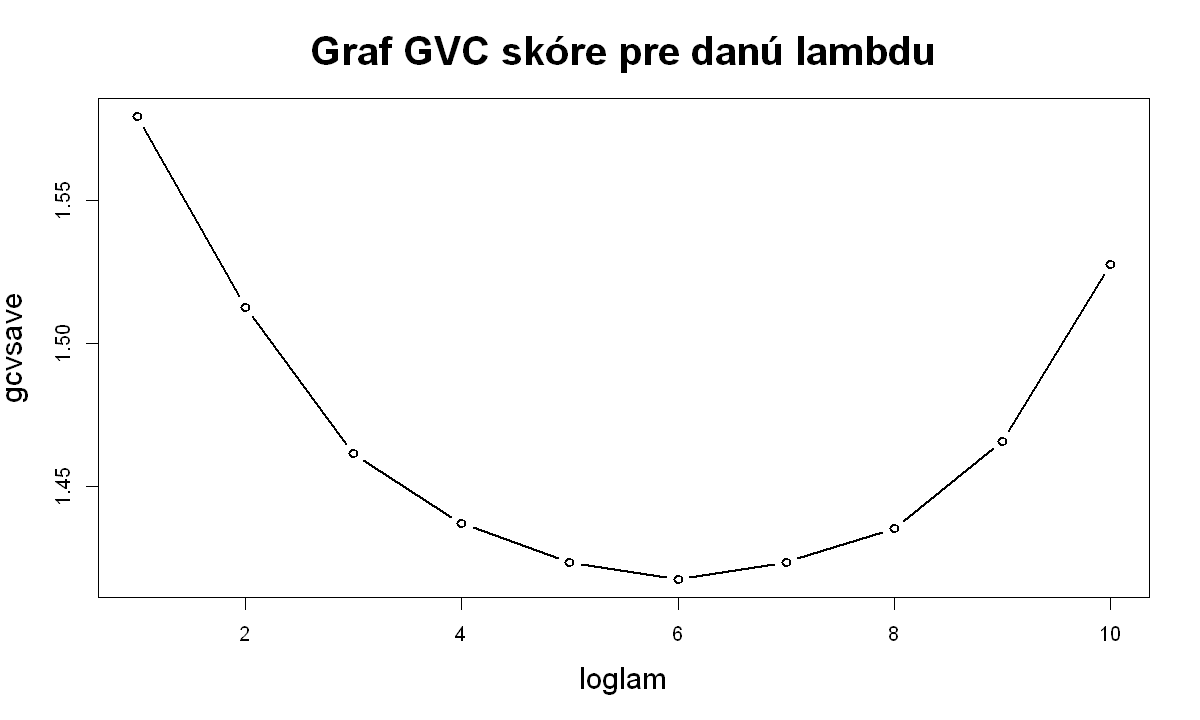

In [47]:
# kod pre vypocet optimalneho parametra lambda podla hore uvedenych vzorcov
Lcoef = c(0,(2*pi/diff(yearRng))^2,0,1)
harmaccelLfd = vec2Lfd(Lcoef, yearRng)

# postupne pre lambda 1 az 10 ratame GVC skore  
loglam = 1:10
nlam = length(loglam)
dfsave = rep(NA,nlam)
names(dfsave) = loglam
gcvsave = dfsave

for (ilam in 1:nlam) {
cat(paste('log10 lambda =',loglam[ilam],'\n'))
lambda = 10^loglam[ilam]
fdParobj = fdPar(daybasis, harmaccelLfd, lambda)
smoothlist = smooth.basis(day.5, logprecav,fdParobj)
dfsave[ilam] = smoothlist$df
gcvsave[ilam] = sum(smoothlist$gcv)
}
options(repr.plot.width=10, repr.plot.height=6)
plot(loglam, gcvsave, type='b', lwd=2, main="Graf GVC skóre pre danú lambdu", cex.main=2, cex.lab=1.5)

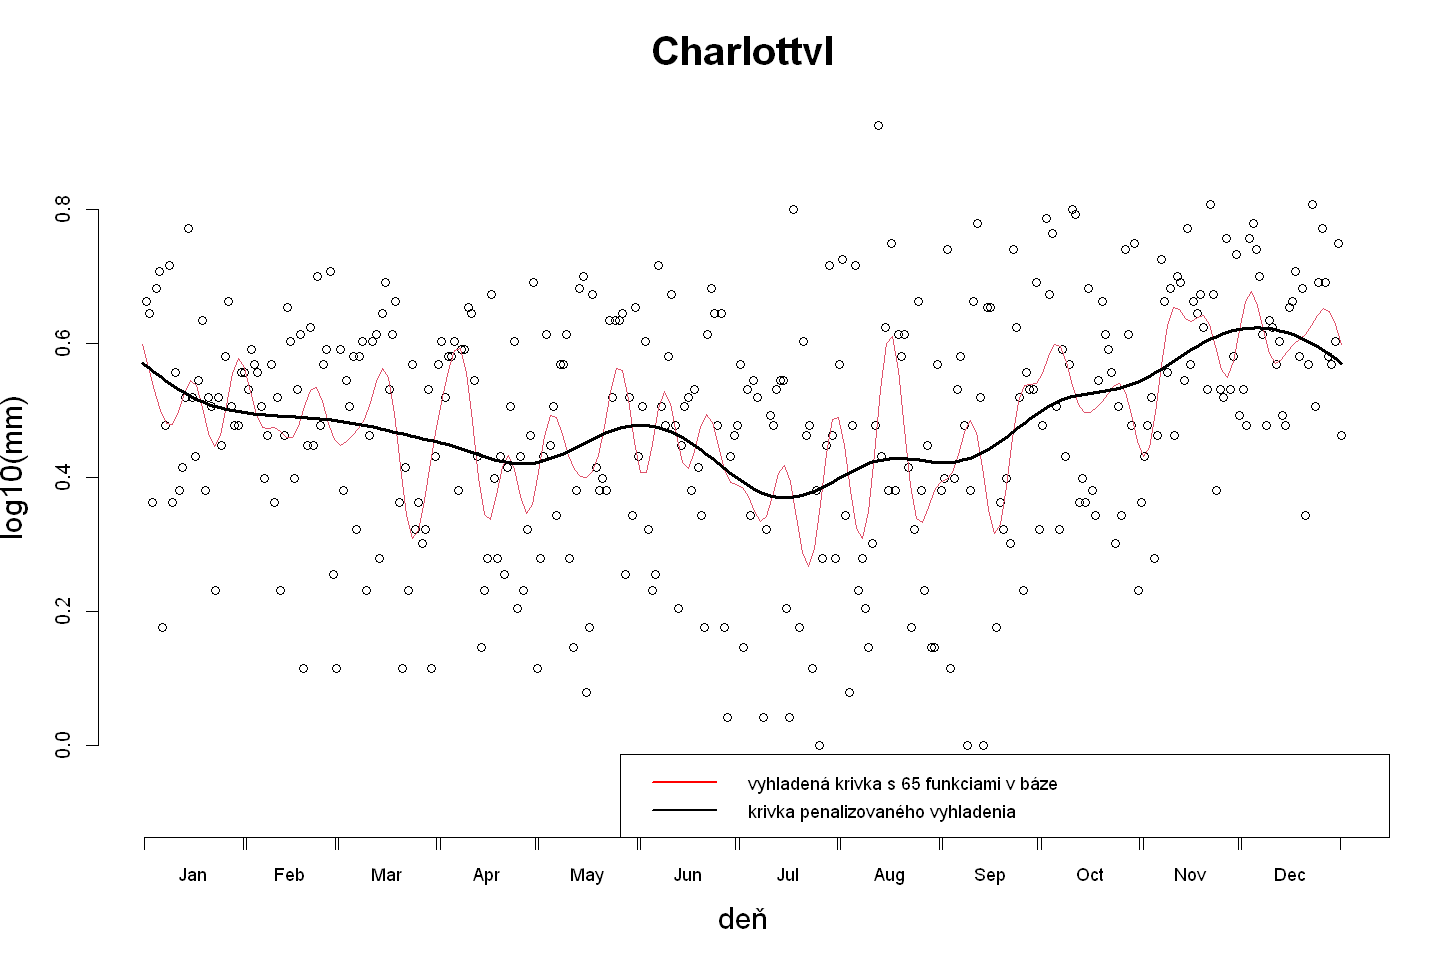

In [48]:
# uvidime, ze pre hodnotu 6 (teda 10^6), mame najnizsie GVC skore a teda pre tuto hodnotu vytvorime prislusnu bazu 

lambda = 1e6
fdParobj = fdPar(daybasis, harmaccelLfd, lambda)
logprec.fit = smooth.basis(day.5, logprecav, fdParobj)
logprec.fd = logprec.fit$fd

# nasledne si body a vyhladene krivky vykreslime
options(repr.plot.width=12, repr.plot.height=8)
plot(logprecav[,i],axes=FALSE,xlab="deň",ylab="log10(mm)",main=CanadianWeather$place[i], cex.main=2, cex.lab=1.5)
lines(dayprecfd[i],col=2)
axisIntervals(1)
axis(2)
lines(logprec.fd[i], lwd=3)
legend("bottomright", legend=c("vyhladená krivka s 65 funkciami v báze", "krivka penalizovaného vyhladenia"),
     col=c("red", "black"),  cex=0.9, lty=1:1, lwd=2)

**<font size=4 color=darkblue> 2.2 Zarovnanie kriviek </font>** <br>

Nasledujúci obrázok obsahuje graf dvoch posunutých sínusových kriviek o nenulovú konštantu s ich krivkou priemeru (červená čiara). Môžeme vidieť, že priemer nezodpovedá veľmi realite, aj keď ide o vizuálne totožné krivky. To znamená, že jej amplitúda nie je totožná s posunutými krivkami (ide o **horizontálne posunutie**). Tento problém rieši práve zarovnanie kriviek. 

Motiváciou prečo chceme (akékoľvek) posunutie eliminovať môže byť to, že biologické či meteorologické časové štandardy sa môžu nelinárne líšiť od fyzikálneho časového štandardu (napr. rast človeka prechádza rovnakým "vzorcom", ale s iným načasovaním).

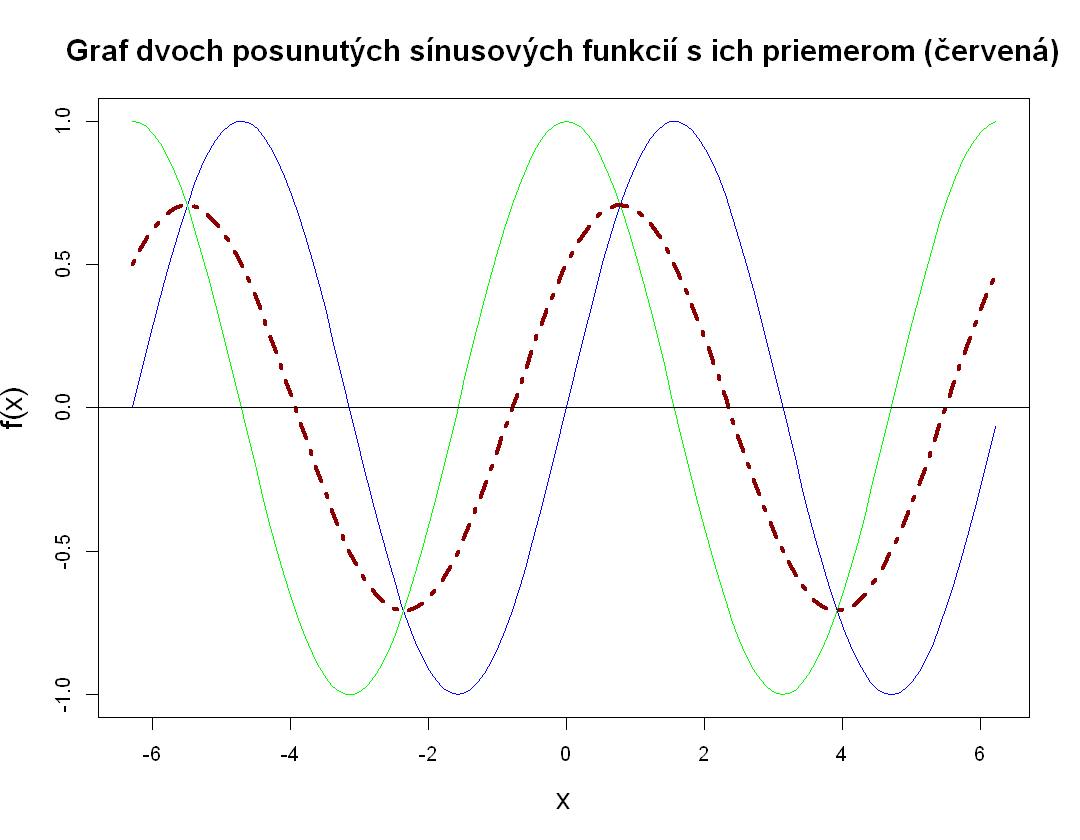

In [49]:
# kod na vykreslenie dvoch sinusovych kriviek a ich priemeru
x <- seq(-2*pi,2*pi,0.1)
options(repr.plot.width=9, repr.plot.height=7)
plot(x, sin(x),
     main="Graf dvoch posunutých sínusových funkcií s ich priemerom (červená)",ylab="f(x)",type="l",col="blue", 
     cex.main=1.5, cex.lab=1.5)
lines(x,cos(x), col="green")
a<-sin(x)
b<-cos(x)

priemer<-function(a,b){
  vysledok<-c()
  for (i in 1:length(a)) {
    vysledok<-c(vysledok, (a[i]+b[i])/2)
  }
  return(vysledok)
}
priemer<-priemer(a,b)
lines(x,priemer, col="darkred", lwd=3.5, lty=4)
abline(0,0)


Okrem amplitúdovej variancie, existuje aj fázová variancia (**vertikálne posunutie**). Nasledujúci kód nám zobrazí graf s vyhladenými rastovými krivkami 54 dievčat vo veku 1 až 18 rokov. 

[1] "done"

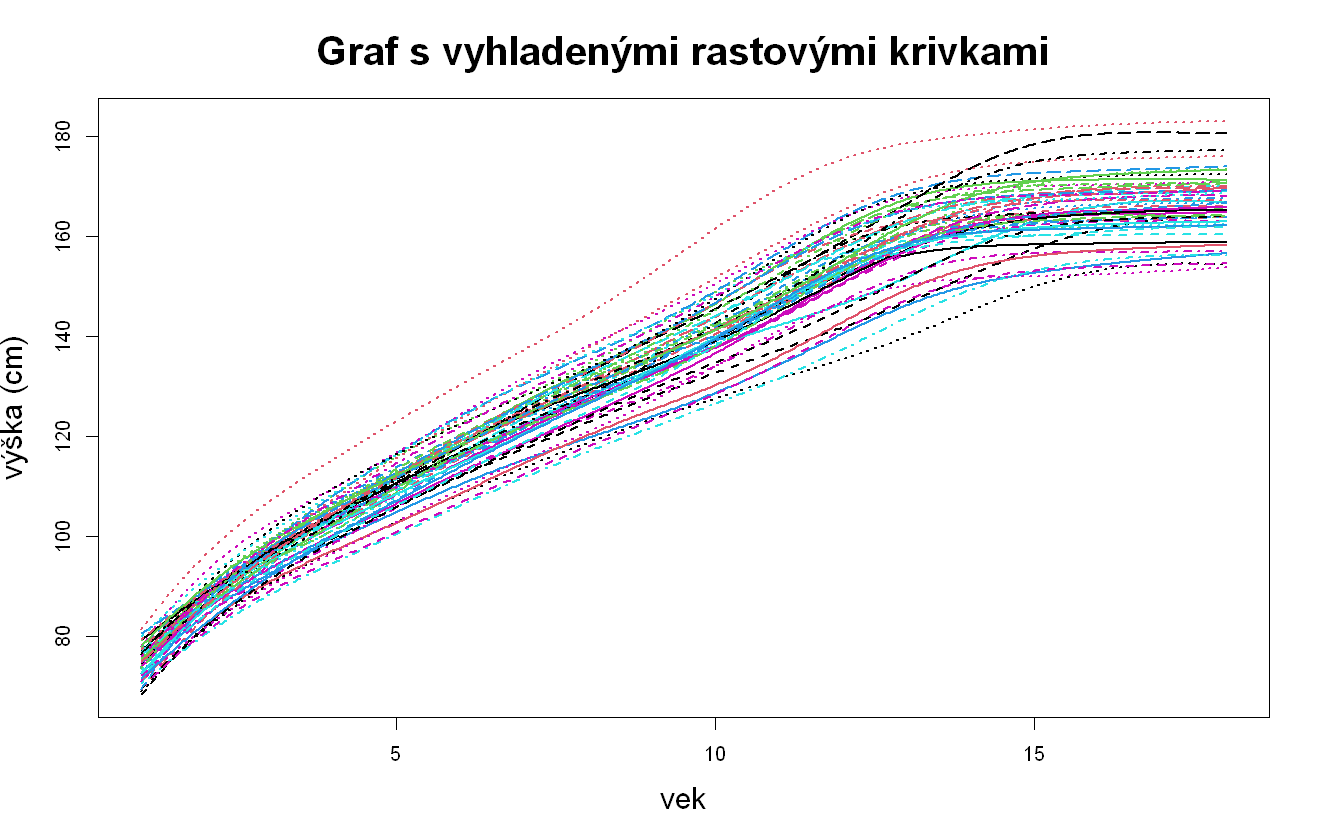

In [50]:
data(DTI)
age=growth$age

# vytvorime si bazu a objekt funkcionalneho parametra
heightBasis=create.bspline.basis( c(1,18), 35, 6, age)
heightPar=fdPar(heightBasis, 3, 10^(-0.5))

# vyhladime a vykreslime vyhladene data
heightSmooth=smooth.basis(age, growth$hgtf, heightPar)
options(repr.plot.width=11, repr.plot.height=7)
plot(heightSmooth, lwd=2, xlab="vek", ylab="výška (cm)", main="Graf s vyhladenými rastovými krivkami", cex.main=2, cex.lab=1.5)

Môžeme vidieť, že krivky sú takmer identické, až na vertikálne posunutie. Práve rastové krivky sú známym príkladom na tento typ variancie. 
Je užitočné vziať do úvahy aj **krivky zrýchlenia** definované ako druhé derivácie rastových kriviek. Tie sú znázornené na nasledujúcom obrázku, ktorý bol získaný pomocou
nasledujúceho kódu.

[1] "done"

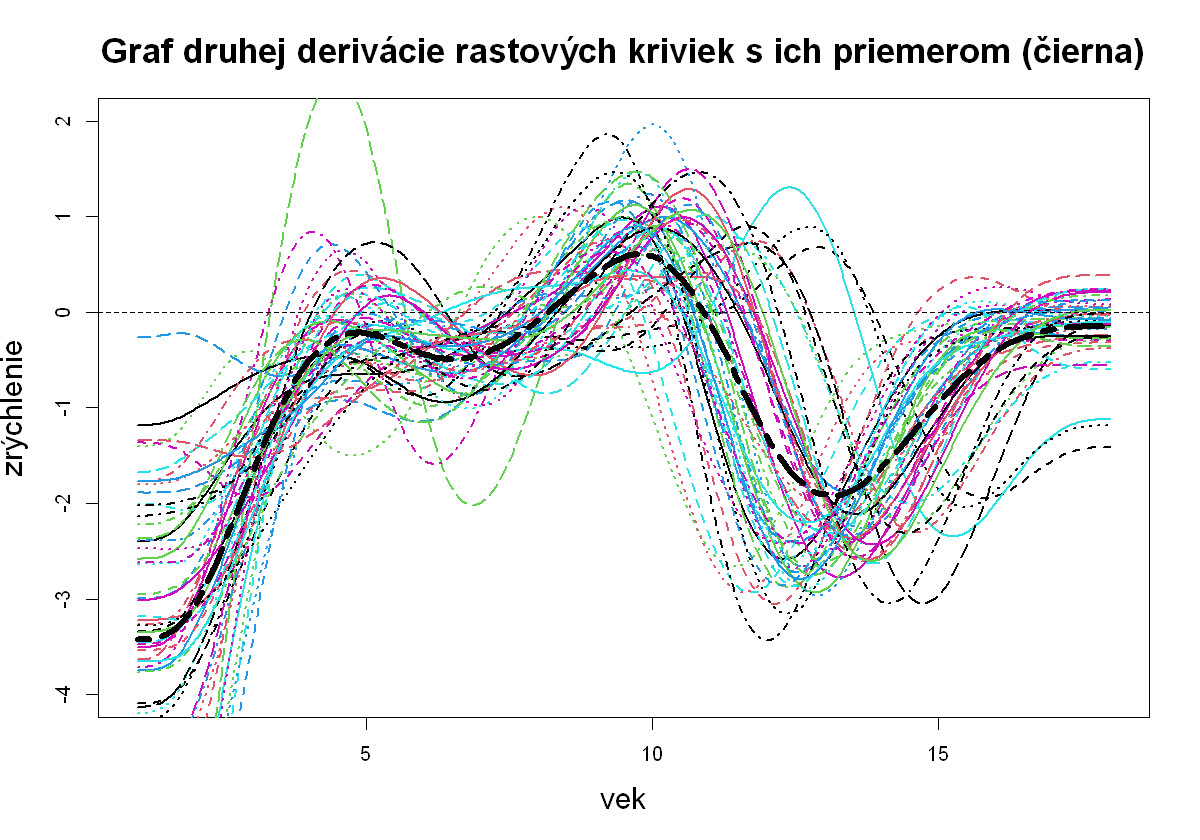

In [51]:
# druha derivacia kriviek s ich priemerov a vykreslenim
accelUnreg = deriv.fd(heightSmooth$fd, 2)
# vykreslenie
options(repr.plot.width=10, repr.plot.height=7)
plot(accelUnreg[,1], lwd=2, xlab="vek", ylab="zrýchlenie", ylim=c(-4,2), 
     main="Graf druhej derivácie rastových kriviek s ich priemerom (čierna)", cex.main=1.75, cex.lab=1.5)
mean.accelUnreg=mean.fd(accelUnreg)
lines(mean.accelUnreg, lwd=5, col="black", lty=6)

Z obrázka môžeme vyčítať, že krivky obsahujú fázovú aj amplitúdovú varianciu a je žiadúce tieto krivky zosúladiť. Tento problém pomáha riešiť „**spojitý prístup**“ (z ang. continuous registration). Tento prístup je založený na zosúladení bodov krivky do orietačných bodov pre každú krivku. 

In [52]:
# samotna nelinearna transformacia
regList=register.fd(yfd=accelUnreg)
accelReg=regList$regfd



-------  Curve  1   --------

Iter.    Criterion   Grad Length
0        0.3291      0.8613
1        0.1747      2e-04
2        0.1747      2e-04

-------  Curve  2   --------

Iter.    Criterion   Grad Length
0        0.2136      0.3625
1        0.1716      0.0033
2        0.1715      9e-04

-------  Curve  3   --------

Iter.    Criterion   Grad Length
0        1.4138      1.4097
1        0.5565      0.0357
2        0.5565      0.0357
3        0.5565      0.0344

-------  Curve  4   --------

Iter.    Criterion   Grad Length
0        0.1723      0.361
1        0.1237      0.0134
2        0.1236      1e-04
3        0.1236      1e-04

-------  Curve  5   --------

Iter.    Criterion   Grad Length
0        0.3813      0.8955
1        0.1668      0.0063
2        0.1667      5e-04
3        0.1667      5e-04

-------  Curve  6   --------

Iter.    Criterion   Grad Length
0        0.1239      0.0509
1        0.1233      0.0017
2        0.1233      3e-04

-------  Curve  7   --------

Iter.

V samotnom výpise môžeme vidieť, že pre každú krivku dochádza k nejakej iterácii, ktorá končí v prípade, ak kritérium už ďalej neklesne. Toto kritérium je minimum vlastnej hodnoty matice $C(h)$, ktorá je definovaná nasledovne: $C(h) = \begin{pmatrix}
    \int{\{x_0(t)\}^2dt} & \int{x_0(t)x[h(t)]dt}  \\
    \int{x_0(t)x[h(t)]dt} & \int{\{x[h(t)]\}^2dt}  
    \end{pmatrix}$.
    
    
Funkcia $h(t)$ je definovaná tak, že pre zarovnanú funkciu platí: $x_i^{\ast}(t)=x_i[h^{-1}(t)]$, kde pre $h(t)$ platí, že $h^{-1}[h(t)]=t$. Práve táto funkcia $h(t)$ nám zosúladí body krivky do orientačných bodov pre každú krivku. A aby to bolo optimálne zosúladenie, tak na to máme maticu $C(h)$.

Teraz si vykreslíme zarovnané druhé derivácie kriviek a môžeme pozorovať, že rozptýlenosť okolo priemeru je nižšie, ako pred zarovnaním.

[1] "done"

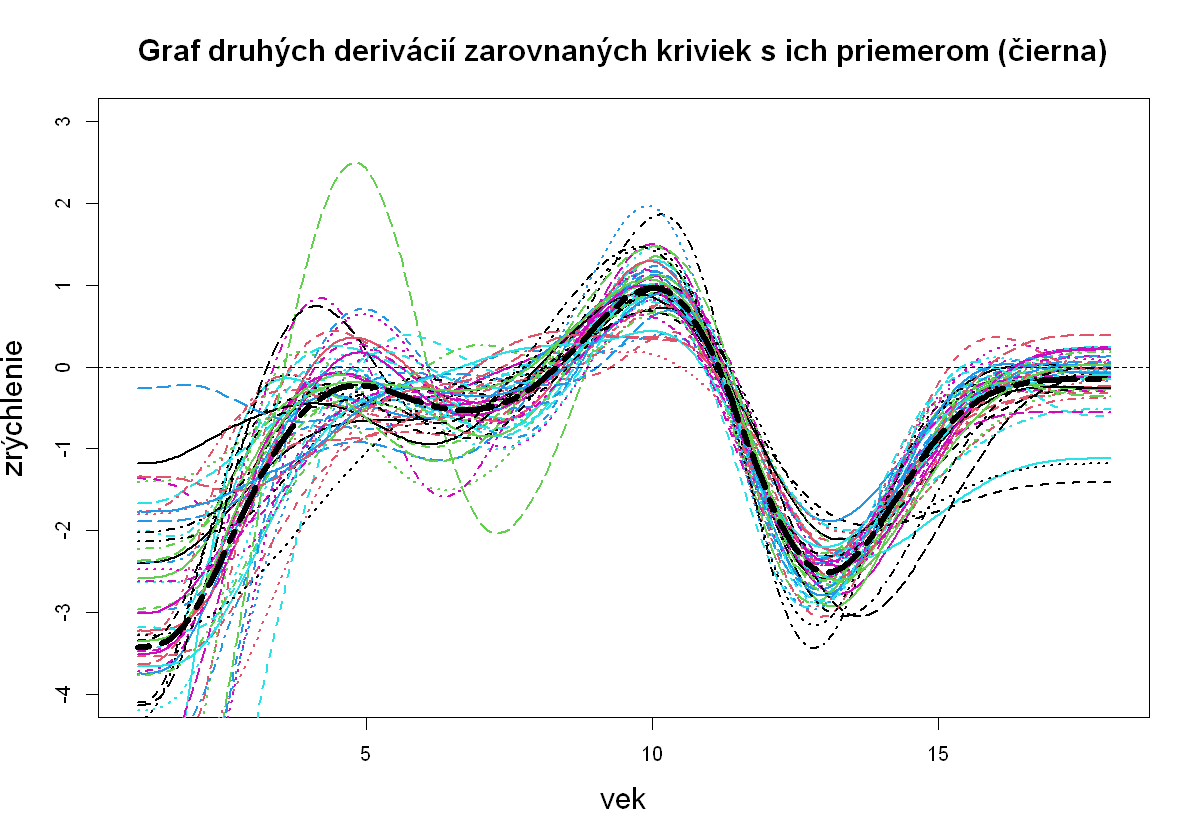

In [53]:
# vykreslenie
options(repr.plot.width=10, repr.plot.height=7)
plot(accelReg, xlab="vek", ylab="zrýchlenie", 
    main="Graf druhých derivácií zarovnaných kriviek s ich priemerom (čierna)",
ylim=c(-4,3), cex.main=1.5, cex.lab=1.5, lwd=2)
mean.accelReg=mean.fd(accelReg)
lines(mean.accelReg, lwd=5, col="black", lty=6)

Na záver dodáme, že toto zarovnanie sa najčastejšie využíva pri krivkách akcelerácie (zrýchlenia), kde sa používa druhá derivácia kriviek. 

--- 

<a id=optimalna_baza></a>
**<font size=5 color=darkblue> 3. Optimálny počet funkcií v báze </font>** <br>

Pri voľbe parametrov vyhladzovania kriviek sa prirodzene vynárajú otázky: aký je optimálny počet funkcií v báze? Vieme nejakým spôsobom určiť optimálny počet funkcií v báze? Odpoveď nám môže poskytnúť napríklad už v predchádzajúcej časti spomínaná metóda krížovej validácie (cross validation - CV). Jej podstata je objasnená nasledujúcimi krokmi:
* 1. vynechať jedno ľubovoľné pozorovanie $(t_{j},Y_{j})$, - test;
* 2. vyhladiť zostávajúce dáta a získať $\hat{X_{j}}(t_{j})$ pre rôzne možnosti $K$, - učenie sa;
* 3. vybrať také $K$, ktoré minimalizuje CV skóre definované ako $CV(X)=\sum_{j=1}^{m}\left(Y_{j}-\hat{X}_{-j}(t_{j})\right)^2$. 

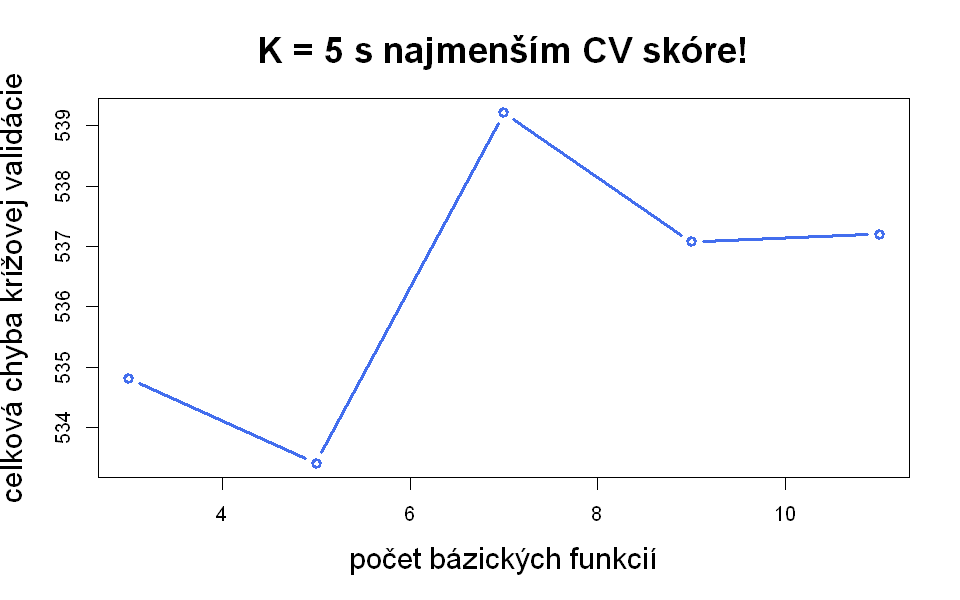

In [54]:
# uvodne technicke upravy dat
y.precip=dailyAv[,,2]
l = which(place=="Quebec") 
t.day = 1:365  
y=y.precip[,l]

# definovanie K, matice a bazy
K.vec = 2*c(1:5)+1; 
CVfit = matrix(0,  nrow=365, ncol=length(K.vec))

fbasis=create.fourier.basis(rangeval = c(1,365), nbasis=max(K.vec), period=365)
bvals = eval.basis(t.day,fbasis)

for(j in 1:365){
  
# vynechanie pozorovania na neskorsie testovanie
  Y.star = y[-j]

# samotne ucenie sa - algoritmus krizovej validacie
index=0
for (K in K.vec){
    index=index+1
    Xbasis=bvals[, 1:K];
    Xbasis.j =  Xbasis[-j, ]; 
    lm.fit = lm(Y.star~0+Xbasis.j) 
    Xbasis.coeff = lm.fit$coefficients
    y.fit = Xbasis%*%Xbasis.coeff
    CVfit[j,index] = (y[j] - y.fit[j])^2
  }
}
CV_L2 = apply(CVfit, 2, sum)

# vizualizacia 
options(repr.plot.width=8, repr.plot.height=5)
plot(K.vec, CV_L2, type="n",
     xlab="počet bázických funkcií", ylab="celková chyba krížovej validácie", cex.lab=1.5)
points(K.vec, CV_L2, type='b', col="royalblue2", lwd=3)
title(paste0("K = ", K.vec[which(CV_L2==min(CV_L2))], " s najmenším CV skóre!"),cex.main=1.8)

Môžeme vidieť, že GCV skóre je najmenšie pre $K=5$. Preto teraz môžeme vyhladiť dáta pre dané konkrétne $K$ pomocou funkcie `gam()` (viď.[dokumentácia](https://www.rdocumentation.org/packages/mgcv/versions/1.8-40/topics/gam)).

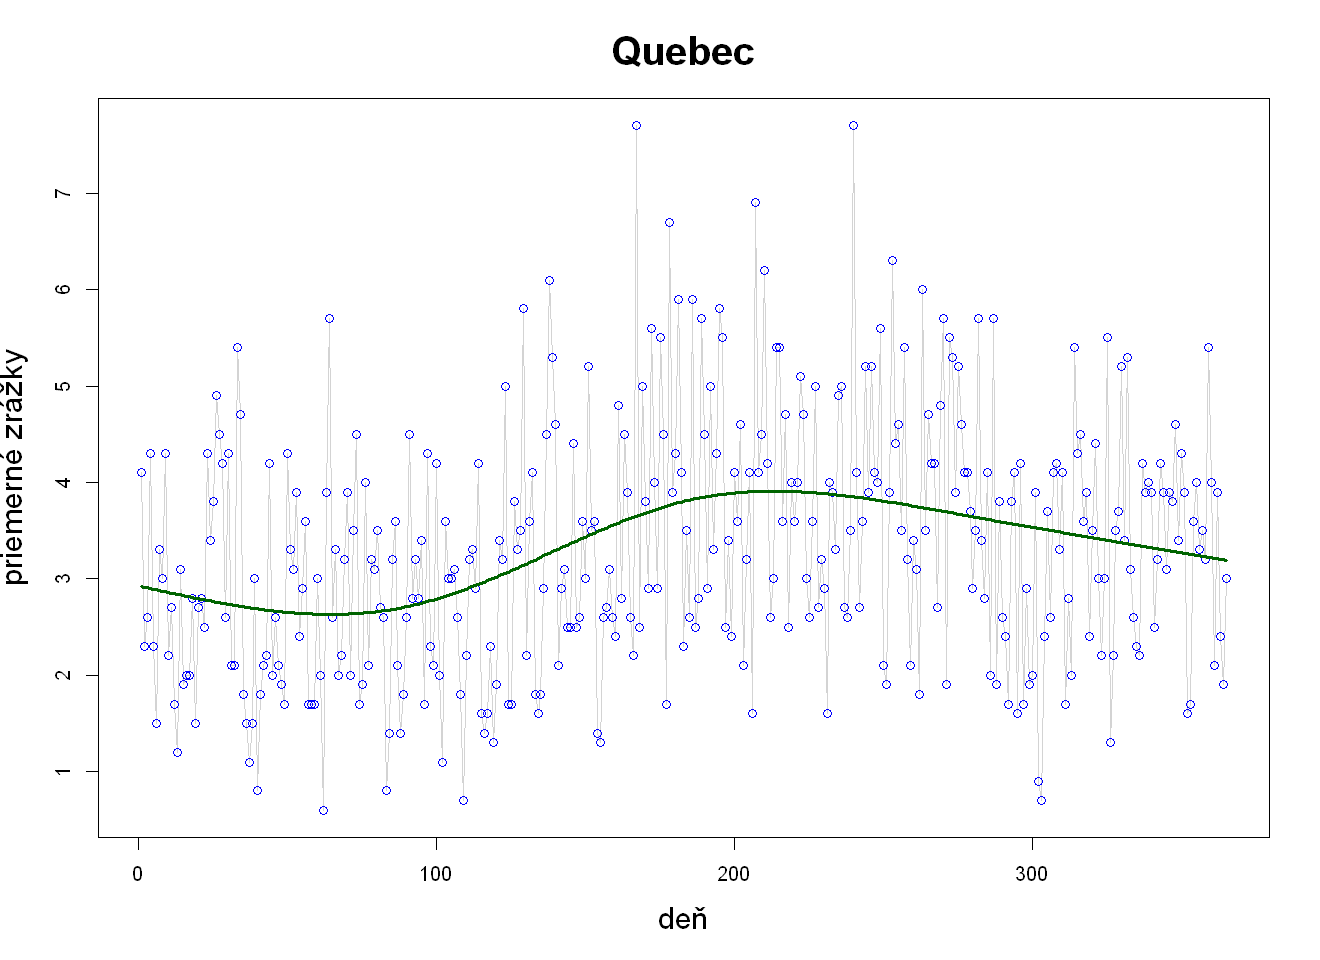

In [55]:
library(mgcv)
# samotne vyhladenie dat s K=5  
fit <- gam(y~s(t.day, k = 5, bs = "cr"), method="REML")
yhat <- fit$fitted

# vizualizacia 
options(repr.plot.width=11, repr.plot.height=8)
plot(t.day, y, type="l", 
     xlab="deň", ylab="priemerné zrážky", main=place[l], col="lightgrey", cex.main=2, cex.lab=1.55)
points(t.day, y, pch=1, col="blue", cex=1)
lines(t.day,  yhat, lwd=3, col="darkgreen")

***
<a id=zdroje></a>
# <font color=darkblue> 4. Zdroje </font>
 
* Goldsmith, J. et al., (2023). refund: Regression with Functional Data. 2023
  

* Kokoszka, P., & Reimherr, M. (2017). Introduction to Functional Data Analysis (1st edition). Chapman and Hall/CRC. 


* Lillestøl, J., & Ollmar, F. (n.d.). Functional data analysis: Introduction and applications to financial electricity contracts. 19.


* Ramsay, J. O., & Silverman, B. W. (2005). Functional data analysis (2nd ed). Springer.


* Ramsay, J., Hooker, G., & Graves, S. (2009). Functional Data Analysis with R and MATLAB. Springer New York. 

  
* Ramsay, J., Hooker, G., & Graves, S. (2022). fda: Functional Data Analysis. 2022


* Staicu, A.-M., & Park, S. Y. (2016). Short Course on Applied Functional Data Analysis. [Online kurz.](https://www4.stat.ncsu.edu/~staicu/FDAtutorial/index.html) 


* Wood SN (2004). “Stable and efficient multiple smoothing parameter estimation for generalized additive models.” Journal of the American Statistical Association, 99(467), 673-686.